__NAME:__ __Nigel Mansell__  
__SECTION #:__ __CS-5970-995__

# Homework 3: Classifiers

### Objectives
Follow the TODOs and read through and understand the provided code.
For this assignment you will work with extracting different types of labels,
constructing predictive classifier models from these labels, and evaluating 
the generalized performance of these models. Additionally, it is good practice 
to have a high level understanding of the data one is working with, thus upon 
loading the data the info and summary statistics are also displayed, in addition
to the head, tail, and whether there are any missing data (flagged as NaNs).

This assignment utilizes code examples from the lecture on classifiers

* Pipelines
* Classification
  + Label extraction and construction
  + Prediction
  + Performance Evaluation
  + Utilization of Built-In Cross Validation Tools

### General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
  + [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Leatn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)

### Hand-In Procedure
* Execute all cells so they are showing correct results
* Notebook:
  + Submit this file (.ipynb) to the Canvas HW3 dropbox
* PDF:
  + File/Print/Print to file -> Produces a copy of the notebook in PDF format
  + Submit the PDF file to the Gradescope HW3 dropbox

import pandas as pd
import numpy as np
import os, re, fnmatch
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier


FIGWIDTH = 6
FIGHEIGHT = 6
FONTSIZE = 12

plt.rcParams['figure.figsize'] = (FIGWIDTH, FIGHEIGHT)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

# LOAD DATA

In [154]:
""" TODO
Load data from subject k2 for week 05
Display info() for the data

These are data obtained from a baby on the SIPPC. 3D Position (i.e. kinematic)
data are collected at 50 Hz, for the x, y, and z positions in meters, for 
various joints such as the wrists, elbows, shoulders, etc.
"""
# may need to adjust the filepath if you are not working on Oscer
fname = '~/Desktop//mlp/mlp_2020/datasets/baby1/subject_k2_w05.csv'

#creating dataframe from file and output the info
baby_data_raw = pd.read_csv(fname)
baby_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              15000 non-null  float64
 1   left_wrist_x      14987 non-null  float64
 2   left_wrist_y      14987 non-null  float64
 3   left_wrist_z      14987 non-null  float64
 4   right_wrist_x     14984 non-null  float64
 5   right_wrist_y     14984 non-null  float64
 6   right_wrist_z     14984 non-null  float64
 7   left_elbow_x      15000 non-null  float64
 8   left_elbow_y      15000 non-null  float64
 9   left_elbow_z      15000 non-null  float64
 10  right_elbow_x     15000 non-null  float64
 11  right_elbow_y     15000 non-null  float64
 12  right_elbow_z     15000 non-null  float64
 13  left_shoulder_x   15000 non-null  float64
 14  left_shoulder_y   15000 non-null  float64
 15  left_shoulder_z   15000 non-null  float64
 16  right_shoulder_x  15000 non-null  float6

In [155]:
""" TODO
Display the first few examples
"""

#displaying the head
display(baby_data_raw.head())

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
0,0.00,0.220415,0.181230,-0.129179,0.234461,-0.235074,-0.058906,0.172050,0.227567,-0.052032,...,-0.117939,-0.214891,-0.051161,-0.248173,0.225993,0.012226,0.021536,0.0,-0.000181,0.004893
1,0.02,0.221667,0.180757,-0.128407,0.233129,-0.237052,-0.058938,0.173125,0.227220,-0.051447,...,-0.123085,-0.215723,-0.051426,-0.248049,0.226178,0.011346,0.021050,0.0,-0.000178,0.004820
2,0.04,0.222194,0.180795,-0.127102,0.231888,-0.238736,-0.058754,0.173883,0.227297,-0.050020,...,-0.122420,-0.217153,-0.052046,-0.247054,0.226289,0.010714,0.020789,0.0,-0.000175,0.004748
3,0.06,0.222396,0.181160,-0.126370,0.230835,-0.240115,-0.058329,0.174341,0.227243,-0.048877,...,-0.121519,-0.218098,-0.052721,-0.246157,0.226414,0.010120,0.020412,0.0,-0.000173,0.004677
4,0.08,0.223019,0.182199,-0.124856,0.230171,-0.241552,-0.058468,0.174702,0.227184,-0.046883,...,-0.122356,-0.219171,-0.053410,-0.244805,0.226513,0.009397,0.020212,0.0,-0.000170,0.004609


In [156]:
""" TODO
Display the last few examples
"""

#displaying the tail
display(baby_data_raw.tail())

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
14995,299.90,0.305730,0.168831,0.033561,0.259778,-0.171445,0.045665,0.238274,0.244787,0.044443,...,-0.212863,-0.072385,-0.137549,-0.260178,0.192844,0.022664,0.080014,8.0,0.001891,0.055393
14996,299.92,0.305648,0.167093,0.034346,0.260100,-0.170313,0.046645,0.239116,0.243905,0.044899,...,-0.213741,-0.071297,-0.136961,-0.260497,0.192431,0.022375,0.080498,8.0,0.001887,0.055518
14997,299.94,0.306012,0.165883,0.035369,0.260067,-0.169648,0.047763,0.240050,0.243200,0.045813,...,-0.214687,-0.070472,-0.136552,-0.260672,0.192087,0.022130,0.080898,8.0,0.001884,0.055618
14998,299.96,0.306393,0.165342,0.036705,0.260300,-0.169104,0.048301,0.240694,0.242808,0.047692,...,-0.215449,-0.070135,-0.136213,-0.260645,0.191871,0.021943,0.081155,8.0,0.001880,0.055695
14999,299.98,0.307053,0.165342,0.038167,0.260593,-0.168929,0.048783,0.241236,0.242589,0.049956,...,-0.215919,-0.070001,-0.136121,-0.260579,0.191652,0.021846,0.081390,8.0,0.001878,0.055752


In [157]:
""" TODO
Display the summary statistics
"""

#calling describe to get summary statistics
baby_data_raw.describe()

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
count,15000.000000,14987.000000,14987.000000,14987.000000,14984.000000,14984.000000,14984.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,149.990000,0.244686,0.125995,-0.016250,0.222374,-0.153784,-0.021553,0.203240,0.157987,0.002500,...,-0.228861,-0.073937,-0.050101,-0.235308,0.183821,-0.025163,0.065818,1.143400,-0.000345,0.003076
std,86.605427,0.049269,0.102700,0.096238,0.060946,0.042294,0.045206,0.046069,0.062485,0.052760,...,0.067573,0.097112,0.045566,0.028536,0.026734,0.046388,0.020480,2.498917,0.004045,0.028319
min,0.000000,0.083382,-0.034872,-0.177069,0.106451,-0.274525,-0.124859,0.110774,0.064651,-0.092058,...,-0.327945,-0.256544,-0.160185,-0.297654,0.133454,-0.092531,0.011274,0.000000,-0.014122,-0.074040
25%,74.995000,0.220651,0.027081,-0.119591,0.170334,-0.177999,-0.060396,0.161956,0.098481,-0.050258,...,-0.285460,-0.164332,-0.088158,-0.254496,0.162355,-0.069502,0.052854,0.000000,-0.001392,-0.012675
50%,149.990000,0.249578,0.126924,-0.010748,0.202907,-0.137865,-0.027056,0.201472,0.140740,0.020384,...,-0.248474,-0.028150,-0.048895,-0.241090,0.174270,-0.046750,0.070823,0.000000,-0.000036,0.001257
75%,224.985000,0.270780,0.227609,0.073604,0.283243,-0.125323,0.011331,0.247348,0.222750,0.035858,...,-0.177103,0.012705,-0.017788,-0.215172,0.209942,0.022537,0.080999,0.000000,0.000716,0.019756
max,299.980000,0.370966,0.320520,0.154593,0.329078,-0.071355,0.151956,0.284781,0.260276,0.176419,...,0.000970,0.035922,0.089456,-0.140069,0.226768,0.047361,0.104098,8.000000,0.016195,0.077659


In [158]:
""" TODO
Check the dataframe for any NaNs using pandas methods
isna() and any() for a summary of the missing data
"""

#checking for nan values
baby_data_raw.isna().any()

time                False
left_wrist_x         True
left_wrist_y         True
left_wrist_z         True
right_wrist_x        True
right_wrist_y        True
right_wrist_z        True
left_elbow_x        False
left_elbow_y        False
left_elbow_z        False
right_elbow_x       False
right_elbow_y       False
right_elbow_z       False
left_shoulder_x     False
left_shoulder_y     False
left_shoulder_z     False
right_shoulder_x    False
right_shoulder_y    False
right_shoulder_z    False
left_knee_x         False
left_knee_y         False
left_knee_z         False
right_knee_x        False
right_knee_y        False
right_knee_z        False
left_ankle_x        False
left_ankle_y        False
left_ankle_z        False
right_ankle_x       False
right_ankle_y       False
right_ankle_z       False
left_foot_x         False
left_foot_y         False
left_foot_z         False
right_foot_x        False
right_foot_y        False
right_foot_z        False
upper_back_x        False
upper_back_y

Text(0, 0.5, 'Action')

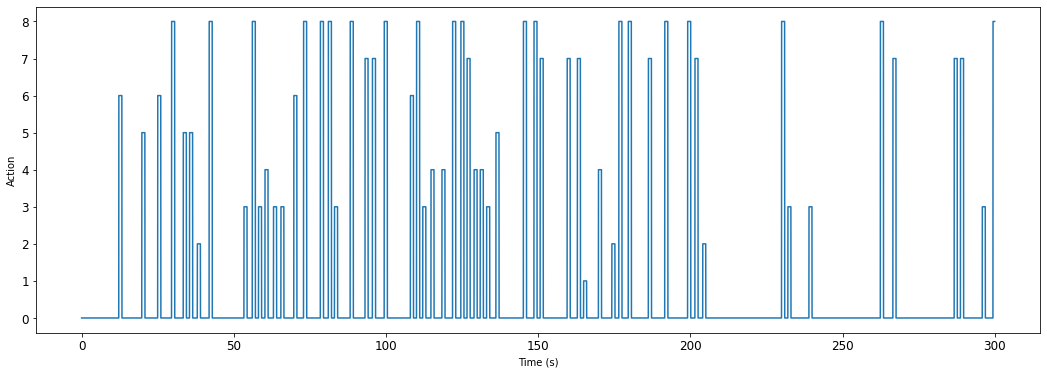

In [159]:
""" TODO
Plot the sippc actions over time for the original dataset.  These actions are short
movements produced by the robot to aid the infant in locomoting in some direction
(forward or left/right turn)
"""

#setting time and action
time = baby_data_raw['time']
action = baby_data_raw['sippc_action']

# TODO: Plot
plt.figure(figsize=(FIGWIDTH*3, FIGHEIGHT))
# TODO: complete this plot of time vs action

#ploting using time and action
plt.plot(time, action)
plt.xlabel("Time (s)")
plt.ylabel("Action")

# Data Selection

In [160]:
""" PROVIDED
"""
## Support for identifying kinematic variable columns
def get_kinematic_properties(data):
    # Regular expression for finding kinematic fields
    regx = re.compile("_[xyz]$")

    # Find the list of kinematic fields
    fields = list(data)
    fieldsKin = [x for x in fields if regx.search(x)]
    return fieldsKin

def position_fields_to_velocity_fields(fields, prefix='d_'):
    '''
    Given a list of position columns, produce a new list
    of columns that include both position and velocity
    '''
    fields_new = [prefix + x for x in fields]
    return fields + fields_new


In [161]:
""" PROVIDED
Get the names of the sets of fields for the kinematic features and the 
velocities
"""
fieldsKin = get_kinematic_properties(baby_data_raw)
fieldsKinVel = position_fields_to_velocity_fields(fieldsKin)
print(fieldsKinVel)

['left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'left_foot_x', 'left_foot_y', 'left_foot_z', 'right_foot_x', 'right_foot_y', 'right_foot_z', 'upper_back_x', 'upper_back_y', 'upper_back_z', 'd_left_wrist_x', 'd_left_wrist_y', 'd_left_wrist_z', 'd_right_wrist_x', 'd_right_wrist_y', 'd_right_wrist_z', 'd_left_elbow_x', 'd_left_elbow_y', 'd_left_elbow_z', 'd_right_elbow_x', 'd_right_elbow_y', 'd_right_elbow_z', 'd_left_shoulder_x', 'd_left_shoulder_y', 'd_left_shoulder_z', 'd_right_shoulder_x', 'd_right_shoulder_y', 'd_right_shoulder_z', 

# Construct Pipeline Components

In [162]:
""" PROVIDED
"""
# Pipeline component: select subsets of attributes
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        return X[self.attribs]

# Pipeline component: drop all rows that contain invalid values
class DataSampleDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        return X.dropna(how='any')

# Pipeline component: Compute derivatives
class ComputeDerivative(BaseEstimator, TransformerMixin):
    def __init__(self, attribs, dt=1.0, prefix='d_'):
        self.attribs = attribs
        self.dt = dt
        self.prefix = prefix
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        # Compute derivatives
        Xout = X.copy()
        for field in self.attribs:
            # Extract the values for this field
            values = Xout[field].values
            # Compute the difference between subsequent values
            diff = values[1:] - values[0:-1]
            # Bring the length to be the same as original data
            np.append(diff, 0)
            # Name of the new field
            name = self.prefix + field
            Xout[name] = pd.Series(diff / self.dt)
        return Xout


# Construct Pipelines

In [163]:
""" PROVIDED
Create four pipelines. 
The first pipeline computes the derivatives of select features
within the dataframe and then drops rows containing NaNs.
The second pipeline extracts the kinematic and velocity (derivative)
features from the dataframe.
The third pipeline extracts the time from the dataframe.
The fourth pipeline extracts the sippc_action from the dataframe.
"""
# Sampling rate: number of seconds between each time sample
dt = .02

# Initial pre-processing
pipe0 = Pipeline([
    ('derivative', ComputeDerivative(fieldsKin, dt=dt)),
    ('dropper', DataSampleDropper())
])

# Position, velocity selector
pipe_kin_vel = Pipeline([
    ('selector', DataFrameSelector(fieldsKinVel))
])

# Time selector
pipe_time = Pipeline([
    ('selector', DataFrameSelector(['time']))
])

# Action selector
pipe_action = Pipeline([
    ('selector', DataFrameSelector(['sippc_action']))
])


## Pre-process and extract data

In [164]:
""" TODO
Use the pipelines to extract the data with kinematic and velocity features, 
the time, and the sippc actions.
See the lecture on classifers for examples
"""
# TODO: use the first pipeline to perform an initial cleaning of the data
#using fit and transform
baby_data_prcd = pipe0.fit_transform(baby_data_raw)

# TODO: Use the result from the first pipeline to get the kinematic and 
#       velocity features by using the pipe_kin_vel pipeline

#used baby data prcd for pipe
data_pos_vel = pipe_kin_vel.transform(baby_data_prcd)

# TODO: Use the result from the first pipeline to get the time by using
#       the pipe_time pipeline

#used baby data prcd for pipe
data_time = pipe_time.transform(baby_data_prcd)

# TODO: Use the result from the first pipeline to get the action by using
#       the pipe_action pipeline

#used baby data prcd for pipe
data_action = pipe_action.transform(baby_data_prcd)


# PROVIDED: Get the dataframes as numpy arrays
inputs_pos_vel = data_pos_vel.values
time = data_time.values
action = data_action.values

nsamples = action.shape[0]
nsamples

14941

## Observing and Obtaining Labels

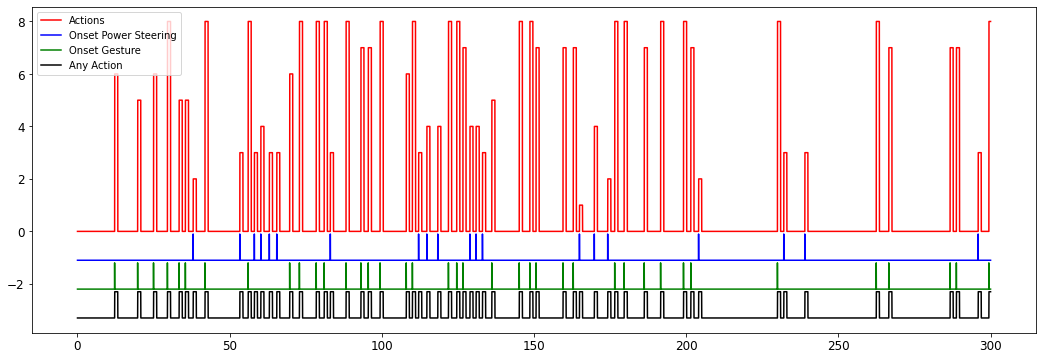

In [165]:
''' PROVIDED
Extract different categories of sippc action labels. Example categories
of actions are no movement versus any-power-steering-movement; or no
movement versus a left-gesture-based-movement.
0: no robot action
1: power-steering: forward
2: power-steering: backward
3: power-steering: left
4: power-steering: right 
5: gesture: forward
6: gesture: backward
7: gesture: left
8: gesture: right 

This function finds all examples where the described action range is just beginning to occur in the next example. 
For example, if the actions np array is [[0],[3],[0],[1],[1],[1],[0],[2]] and lower = 1 and upper = 2, the function
would return [[0],[0],[1],[0],[0],[0],[1],[0]]

actions[0:-1] is the array of actions for time steps 0, 1, ... N-2 (where N is the length of the array)
action[1:] is the array of actions    for time steps 1, 2. ... N-1

'''
def get_action_onsets(actions, lower, upper):
    # Current element is zero; the next element is between lower and upper.
    #  The Boolean operators are done element-by-element
    onsets = (actions[0:-1] == 0) & (actions[1:] >= lower) & (actions[1:] <= upper)
    # Append a zero to keep the lengths the same
    onsets = np.append(onsets, 0)
    return onsets

# Action all movement
label_motion = action > 0

# Action onsets of movements
label_onset_any = get_action_onsets(action, 1, 8) # any action
label_onset_ps = get_action_onsets(action, 1, 4) # power steering
label_onset_g = get_action_onsets(action, 5, 8) # gesture


# Compare the label categories
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.plot(time, action, 'r', label='Actions')
plt.plot(time, label_onset_ps-1.1, 'b', label='Onset Power Steering')
plt.plot(time, label_onset_g-2.2, 'g', label='Onset Gesture')
#plt.plot(time, label_onset_any-3.3, 'k', label='Onset Any')
plt.plot(time, label_motion-3.3, 'k', label='Any Action')
plt.legend(loc='upper left')

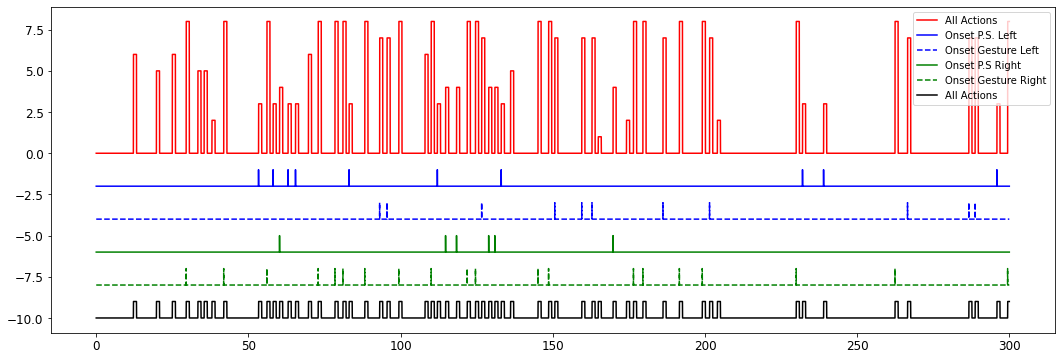

In [166]:
""" PROVIDED
Extract left and right movement onsets from power steering and gesture actions
"""
label_onset_ps_l = get_action_onsets(action, 3, 3) # left power steering
label_onset_ps_r = get_action_onsets(action, 4, 4) # right power steering
label_onset_g_l = get_action_onsets(action, 7, 7) # left gesture
label_onset_g_r = get_action_onsets(action, 8, 8) # right gesture

# Any left action onset: Left power steering OR left gesture
label_onset_l = label_onset_ps_l | label_onset_g_l

# Any right action onset: Right power steering OR right gesture
label_onset_r = label_onset_ps_r | label_onset_g_r


# Compare the labels categories
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.plot(time, action, 'r', label='All Actions')
plt.plot(time, label_onset_ps_l-2, 'b', label='Onset P.S. Left')
plt.plot(time, label_onset_g_l-4, 'b--', label='Onset Gesture Left')
plt.plot(time, label_onset_ps_r-6, 'g', label='Onset P.S Right')
plt.plot(time, label_onset_g_r-8, 'g--', label='Onset Gesture Right')
plt.plot(time, label_motion-10, 'k', label='All Actions')
plt.legend()

In [167]:
""" PROVIDED
"""
def compute_magnitude(mtx):
    '''
    Compute the magnitude as sqrt( sum_i(mtx[i]**2) )
    '''
    return np.sqrt((mtx * mtx).sum(axis=1))

#### EXTRACT AND CONSTRUCT DISTANCE LABELS

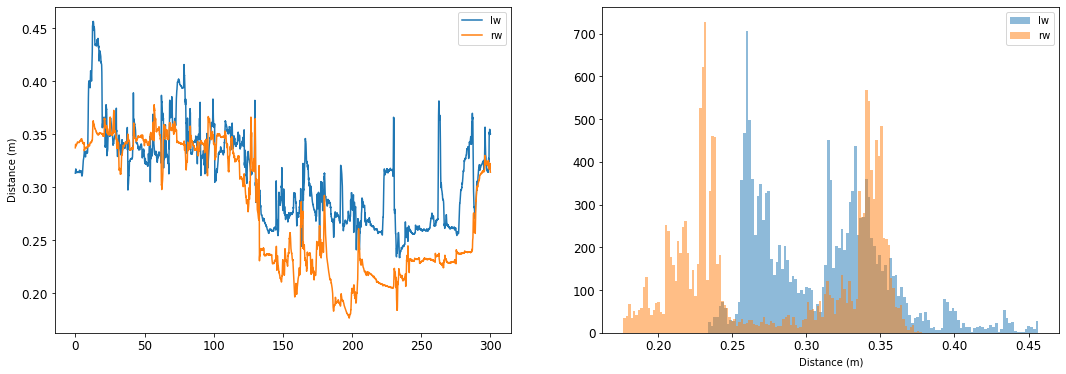

In [168]:
""" TODO
DISTANCE
Generate labels using the magnitude of the position (distance from the baby's 
origin) for the left and right wrists.
Compute the magnitude of the left and right wrists' 3D-position-vector (e.g. 
use the left_wrist_x, left_wrist_y, and left_wrist_z as a matrix to compute
the magnitude at each time point.)
Plot the magnitudes over time comparing left and right, and compare the histograms
for the left and right magnitudes. These magnitudes are the distances of the 
wrists from the baby's origin in 3D space. This is not the best metric to determine movement, 
however, clear differences in the left and right distances can be observed.
"""
# Lists of position coordinate names
lw_pos_comp_names = ['left_wrist_x', 'left_wrist_y', 'left_wrist_z']
rw_pos_comp_names = ['right_wrist_x', 'right_wrist_y', 'right_wrist_z']

# Select the position coordinates
lw_pos = data_pos_vel[lw_pos_comp_names]
rw_pos = data_pos_vel[rw_pos_comp_names]

# TODO: compute the magnitude for the positions (i.e. the distances) for
#       the left and right wrists at every time point using the provided function

#calling magnitude function
lw_dist = compute_magnitude(lw_pos)
rw_dist = compute_magnitude(rw_pos)


# Number of bins for the histogram
nbins = int(np.sqrt(len(lw_dist)))

# PROVIDED: Compare the magnitudes for the left and right positions
# With labels and legends
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.subplot(1,2,1)
plt.plot(time, lw_dist, label='lw')
plt.plot(time, rw_dist, label='rw')
plt.ylabel('Distance (m)')
plt.legend()
plt.subplot(1,2,2)
plt.hist(lw_dist, bins=nbins, alpha=.5, label='lw')
plt.hist(rw_dist, bins=nbins, alpha=.5, label='rw')
plt.xlabel('Distance (m)')
plt.legend()

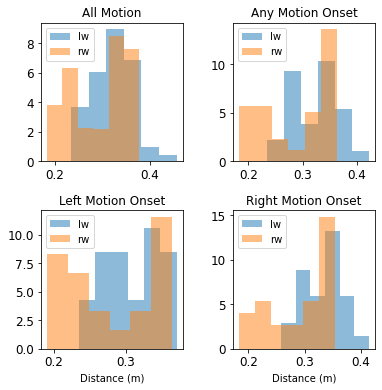

In [169]:
""" PROVIDED
DISTANCE
Histograms of left vs right distances for various motion categories
"""
fig, axs = plt.subplots(2,2, figsize=(FIGWIDTH,FIGHEIGHT))
fig.subplots_adjust(wspace=.35, hspace=.35)
axs = axs.ravel()
label_sets = (label_motion, label_onset_any, label_onset_l, label_onset_r)
label_sets_names = ('All Motion', 'Any Motion Onset', 'Left Motion Onset', 'Right Motion Onset')
label_sets_zip = zip(label_sets, label_sets_names)
for i, (label_set, name) in enumerate(label_sets_zip):
    label_set = label_set.astype(bool).ravel()
    axs[i].hist(lw_dist[label_set], bins=6, density=True, alpha=.5, label='lw')
    axs[i].hist(rw_dist[label_set], bins=6, density=True, alpha=.5, label='rw')
    if i > 1: axs[i].set_xlabel('Distance (m)')
    axs[i].set_title(name)
    axs[i].legend()

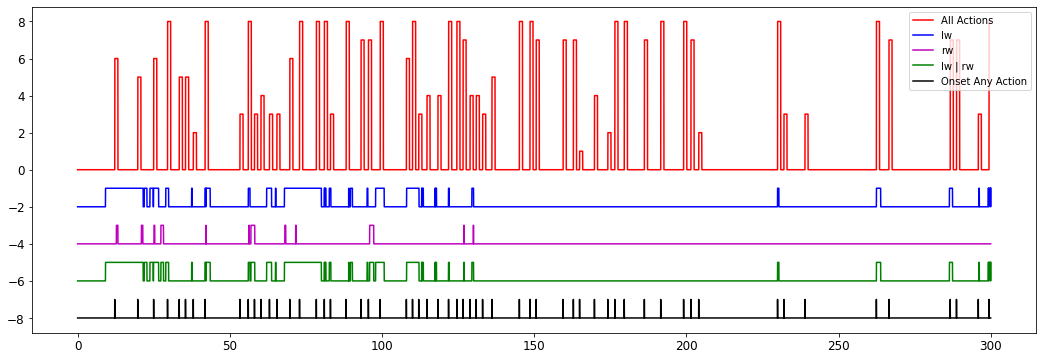

In [170]:
""" TODO
DISTANCE
Generate labels based on the magnitude of the position (distance) of the wrists.
Labels are set as whether the left wrist magnitude exceeds .35 OR the right 
wrist exceeds .36
"""
# TODO: Extract the left wrist distance labels (i.e. 1 where ever the distance 
#       of the left wrist exceeds .35). use lw_dist

#using list comprehension to fill with 0s and 1s
lw_dist_lbls = np.array([1 if i > .35 else 0 for i in lw_dist])

# TODO: Extract the right wrist distance labels (i.e. 1 where ever the distance
#       of the right wrist exceeds .36). use rw_dist

#using list comprehension to fill with 0s and 1s
rw_dist_lbls = np.array([1 if i > .36 else 0 for i in rw_dist])


# TODO: Construct labels 1 when either the left wrist distance exceeds .35 OR 
#       the right wrist distance exceeds .36

#using list comprehension with zip to fill with 0s and 1s
dist_lbls = np.array([1 if i > .35 or j > .36 else 0 for i, j in zip(lw_dist, rw_dist)])

# PROVIDED: Compare the labels
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.plot(time, action, 'r', label='All Actions')
plt.plot(time, lw_dist_lbls-2, 'b', label='lw')
plt.plot(time, rw_dist_lbls-4, 'm', label='rw')
plt.plot(time, dist_lbls-6, 'g', label='lw | rw')
plt.plot(time, label_onset_any-8, 'k', label='Onset Any Action')
plt.legend()

#### EXTRACT AND CONSTRUCT SPEED LABELS

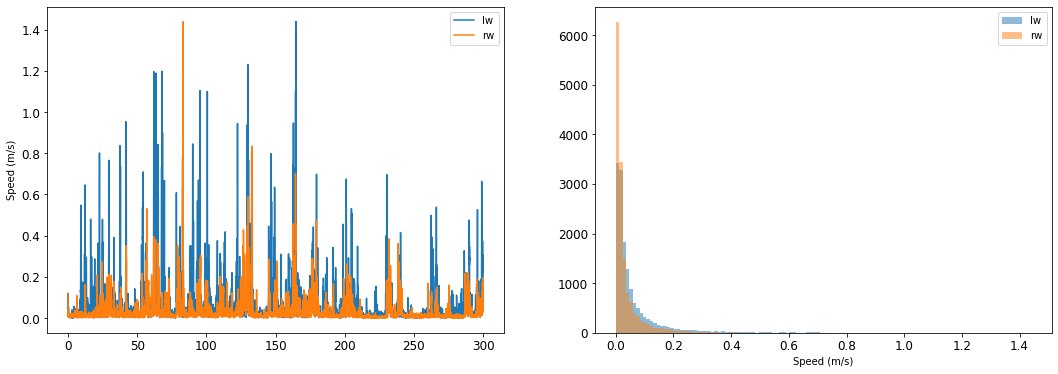

In [171]:
""" TODO
SPEED
Compute the magnitude of the left and right wrists' 3D-velocity-vector (e.g. 
use the d_left_wrist_x, d_left_wrist_y, and d_left_wrist_z as a matrix to compute
the magnitude at each time point.)
Plot the magnitudes over time comparing left and right, and compare the histograms
for the left and right magnitudes. These magnitudes are the speeds of the 
baby's wrists.
Compute the magnitudes, plot the magnitudes over time comparing left and right,
and compare the histograms for the left and right
"""
# Lists of velocity coordinate names
lw_vel_comp_names = ['d_left_wrist_x', 'd_left_wrist_y', 'd_left_wrist_z']
rw_vel_comp_names = ['d_right_wrist_x', 'd_right_wrist_y', 'd_right_wrist_z']

# Select the velocity coordinates
lw_vel = data_pos_vel[lw_vel_comp_names]
rw_vel = data_pos_vel[rw_vel_comp_names]

# TODO: compute the magnitude for the velocities (i.e. the speeds) at every time point
#       using the provided function

#calling magnitude function
lw_spd = compute_magnitude(lw_vel)
rw_spd = compute_magnitude(rw_vel)


# PROVIDED: Compare the magnitudes for the left and right velocites
# With labels and legends
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.subplot(1,2,1)
plt.plot(time, lw_spd, label='lw')
plt.plot(time, rw_spd, label='rw')
plt.ylabel("Speed (m/s)")
plt.legend()
plt.subplot(1,2,2)
plt.hist(lw_spd, bins=nbins, alpha=.5, label='lw')
plt.hist(rw_spd, bins=nbins, alpha=.5, label='rw')
plt.xlabel("Speed (m/s)")
plt.legend()

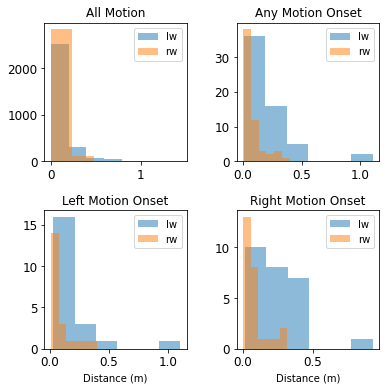

In [172]:
""" PROVIDED
SPEED
Histograms of left vs right speeds for various motion categories
"""
fig, axs = plt.subplots(2,2, figsize=(FIGWIDTH,FIGHEIGHT))
fig.subplots_adjust(wspace=.35, hspace=.35)
axs = axs.ravel()
label_sets = (label_motion, label_onset_any, label_onset_l, label_onset_r)
label_sets_names = ('All Motion', 'Any Motion Onset', 'Left Motion Onset', 'Right Motion Onset')
label_sets_zip = zip(label_sets, label_sets_names)
for i, (label_set, name) in enumerate(label_sets_zip):
    label_set = label_set.astype(bool).ravel()
    axs[i].hist(lw_spd[label_set], bins=6, alpha=.5, label='lw')
    axs[i].hist(rw_spd[label_set], bins=6, alpha=.5, label='rw')
    if i > 1: axs[i].set_xlabel('Distance (m)')
    axs[i].set_title(name)
    axs[i].legend()

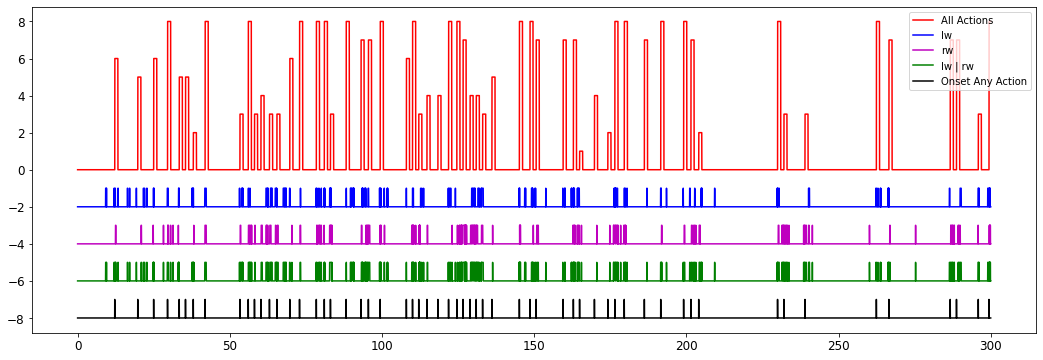

In [173]:
""" TODO
SPEED
Generate labels based on the speed of the wrists. Labels are set as whether 
the left wrist speed exceeds .24 OR the right wrist speed exceeds .13. 
"""
# TODO: Extract the left wrist speed labels (i.e. 1 where ever the speed of 
#       the left wrist exceeds .24). use lw_spd

#using list comprehension to fill with 0s and 1s
lw_spd_lbls = np.array([1 if i > .24 else 0 for i in lw_spd])

# TODO: Extract the right wrist speed labels (i.e. 1 where ever the speed of 
#       the right wrist exceeds .13). use lw_spd

#using list comprehension to fill with 0s and 1s
rw_spd_lbls = np.array([1 if i > .13 else 0 for i in rw_spd])

# TODO: Construct labels 1 when either the left wrist speed exceeds .24 OR 
#       the right wrist speed exceeds .13

#using list comprehension and zip to fill with 0s and 1s
spd_lbls = np.array([1 if i > .24 or j > .13 else 0 for i, j in zip(lw_spd, rw_spd)])


# PROVIDED: Compare the labels
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.plot(time, action, 'r', label='All Actions')
plt.plot(time, lw_spd_lbls-2, 'b', label='lw')
plt.plot(time, rw_spd_lbls-4, 'm', label='rw')
plt.plot(time, spd_lbls-6, 'g', label='lw | rw')
plt.plot(time, label_onset_any-8, 'k', label='Onset Any Action')
plt.legend()

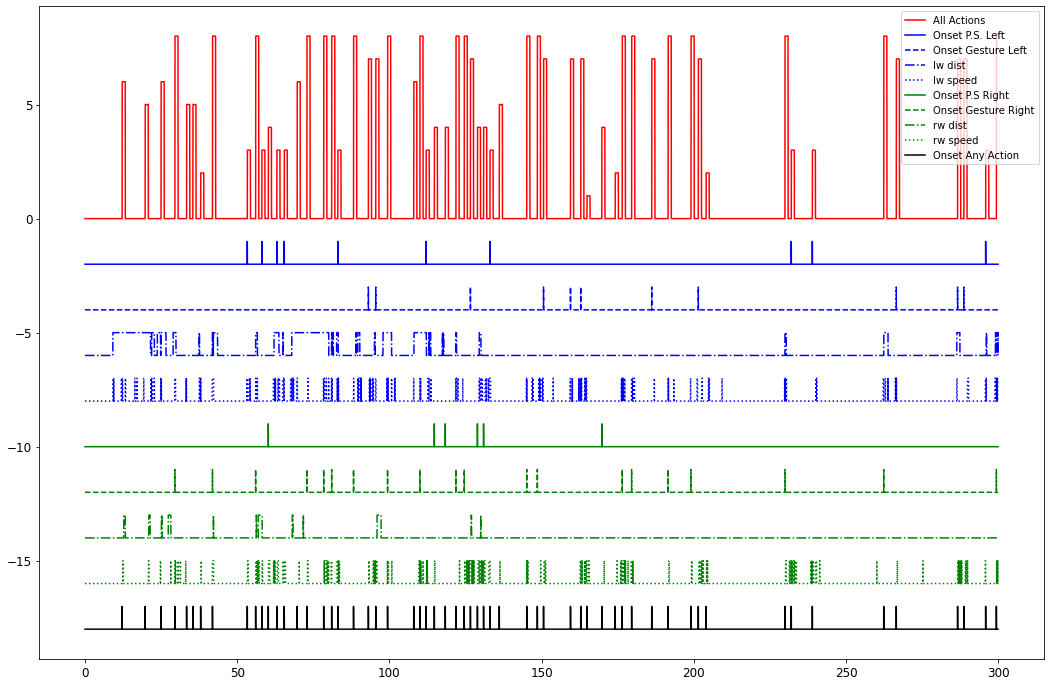

In [174]:
""" PROVIDED
Plot all the label types for left and right
"""
plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT*2))
plt.plot(time, action, 'r', label='All Actions')
plt.plot(time, label_onset_ps_l-2, 'b', label='Onset P.S. Left')
plt.plot(time, label_onset_g_l-4, 'b--', label='Onset Gesture Left')
plt.plot(time, lw_dist_lbls-6, 'b-.', label='lw dist')
plt.plot(time, lw_spd_lbls-8, 'b:', label='lw speed')
plt.plot(time, label_onset_ps_r-10, 'g', label='Onset P.S Right')
plt.plot(time, label_onset_g_r-12, 'g--', label='Onset Gesture Right')
plt.plot(time, rw_dist_lbls-14, 'g-.', label='rw dist')
plt.plot(time, rw_spd_lbls-16, 'g:', label='rw speed')
plt.plot(time, label_onset_any-18, 'k', label='Onset Any Action')
plt.legend()

# Classification Using Cross Validation

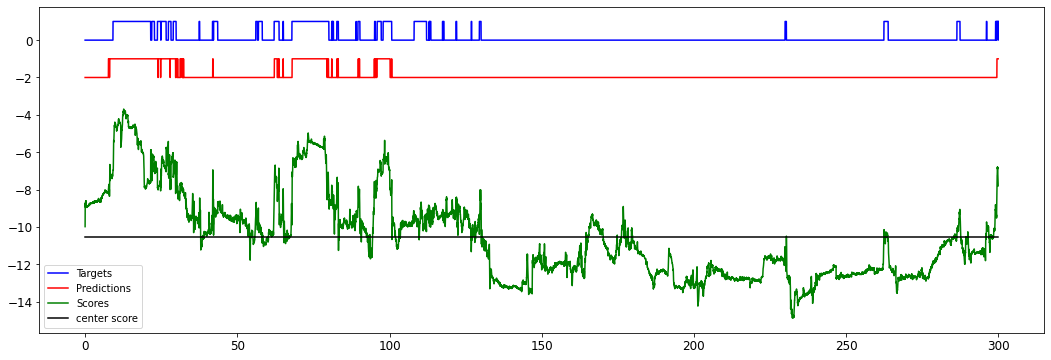

In [180]:
""" TODO
DISTANCE
Create a SGDClassifier with random_state=42, max_iter=1e4, tol=1e-3, and
that uses a log loss function. Fit the model using the position x, y, z
and velocity x, y, z for all limbs as the input features to the model. Use
the distance labels as the output of the model.
Use cross_val_predict() to get predictions for each sample and their
cooresponding scores. Use 20 cross validation splits (i.e. cv=20).
Plot the true labels, predictions, and the scores.
For more information observe the general references above
"""
# Model input
X = inputs_pos_vel
# Model output
y = dist_lbls

# TODO: Create and fit the classifer

#passing over what is in the comment above
clf = SGDClassifier(loss = 'log', random_state=42, max_iter=1e4, tol=1e-3)
clf.fit(X, y)

# TODO: use cross_val_predict() to compute the scores by setting the method
#       parameter equal to 'decision_function'. Please see the reference links above

#calling the imported function, passing the params specified
dist_scores = cross_val_predict(clf, X, y, cv=20, method='decision_function')

# TODO: use cross_val_predict() to compute the predicted labels by setting the method
#       parameter equal to 'predict'. Please see the reference links above

#calling the imported function, passing the params specified
dist_preds = cross_val_predict(clf, X, y, cv=20, method='predict')


# PROVIDED: Compare the true labels to the predicted labels and the scores
mu_score = np.mean(dist_scores)

plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.plot(time, dist_lbls, 'b', label='Targets')
plt.plot(time, dist_preds-2, 'r', label='Predictions')
plt.plot(time, dist_scores-8, 'g', label='Scores')
plt.plot([0, time.max()], [mu_score-8, mu_score-8], 
         'k', label='center score')
plt.legend()

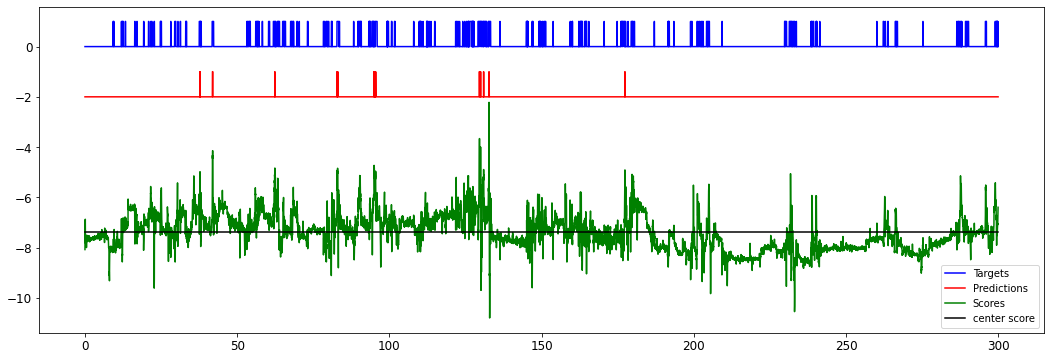

In [181]:
""" TODO
SPEED
Create a SGDClassifier with random_state=42, max_iter=10000, tol=1e-3, and
that uses a log loss function. Fit the model using the position x, y, z
and velocity x, y, z for all limbs as the input features to the model. Use
the speed labels as the output of the model.
Use cross_val_predict() to get predictions for each sample and their
cooresponding score. Use 20 cross validation splits. Predict the speed labels
Plot the true labels, predictions, and the scores
"""
# Model output
y = spd_lbls

# TODO: Create and fit the classifer

#passing over what is commented above
clf = SGDClassifier(loss='log', random_state=42, max_iter=10000, tol=1e-3)
# TODO: fit the classifier
clf.fit(X,y)
# TODO: use cross_val_predict() to compute the scores by setting the method
#       parameter equal to 'decision_function'. Please see the reference links above

#calling the imported function, passing the params specified
spd_scores = cross_val_predict(clf, X, y, cv=20, method='decision_function')

# TODO: use cross_val_predict() to compute the predicted labels by setting the method
#       parameter equal to 'predict'. Please see the reference links above

#calling the imported function, passing the params specified
spd_preds = cross_val_predict(clf, X, y, cv=20, method='predict')


# PROVIDED: Compare the true labels to the predicted labels and the scores
mu_score = np.mean(spd_scores)

plt.figure(figsize=(FIGWIDTH*3,FIGHEIGHT))
plt.plot(time, spd_lbls, 'b', label='Targets')
plt.plot(time, spd_preds-2, 'r', label='Predictions')
plt.plot(time, spd_scores-5, 'g', label='Scores')
plt.plot([0, time.max()], [mu_score-5, mu_score-5], 
         'k', label='center score')
plt.legend()

# Plotting Functions - Performance Results
* Confusion Matrix Color Map
* K.S. Plot
* ROC Curve Plot

In [182]:
""" PROVIDED
"""
# Generate a color map plot for a confusion matrix
def confusion_mtx_colormap(mtx, xnames, ynames, cbarlabel=""):
    ''' 
    Generate a figure that plots a colormap of a matrix
    PARAMS:
        mtx: matrix of values
        xnames: list of x tick names
        ynames: list of the y tick names
        cbarlabel: label for the color bar
    RETURNS:
        fig, ax: the corresponding handles for the figure and axis
    '''
    nxvars = mtx.shape[1]
    nyvars = mtx.shape[0]
    
    # create the figure and plot the correlation matrix
    fig, ax = plt.subplots()
    im = ax.imshow(mtx, cmap='summer')
    if not cbarlabel == "":
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    # Specify the row and column ticks and labels for the figure
    ax.set_xticks(range(nxvars))
    ax.set_yticks(range(nyvars))
    ax.set_xticklabels(xnames)
    ax.set_yticklabels(ynames)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, 
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    lbl = np.array([['TN', 'FP'], ['FN', 'TP']])
    for i in range(nyvars):
        for j in range(nxvars):
            text = ax.text(j, i, "%s = %.3f" % (lbl[i,j], mtx[i, j]),
                           ha="center", va="center", color="k")
            #text.set_path_effects([peffects.withStroke(linewidth=2, 
            #foreground='w')])

    return fig, ax

# Compute the ROC Curve and generate the KS plot
def ks_roc_plot(targets, scores, FIGWIDTH=12, FIGHEIGHT=6, FONTSIZE=16):
    ''' 
    Generate a figure that plots the ROC Curve and the distributions of the 
    TPR and FPR over a set of thresholds
    PARAMS:
        targets: list of true target labels
        scores: list of predicted labels or scores
    RETURNS:
        fpr: false positive rate
        tpr: true positive rate
        thresholds: thresholds used for the ROC curve
        auc: Area under the ROC Curve
        fig, axs: corresponding handles for the figure and axis
    '''
    fpr, tpr, thresholds = roc_curve(targets, scores)
    auc_res = auc(fpr, tpr)

    # Generate KS plot
    fig, ax = plt.subplots(1, 2, figsize=(FIGWIDTH,FIGHEIGHT))
    axs = ax.ravel()
    ax[0].plot(thresholds, tpr, color='b')
    ax[0].plot(thresholds, fpr, color='r')
    ax[0].plot(thresholds, tpr - fpr, color='g')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('threshold', fontsize=FONTSIZE)
    ax[0].set_ylabel('fraction', fontsize=FONTSIZE)
    ax[0].legend(['TPR', 'FPR', 'K-S Distance'], fontsize=FONTSIZE)
    
    # Generate ROC Curve plot
    ax[1].plot(fpr, tpr, color='b')
    ax[1].plot([0,1], [0,1], 'r--')
    ax[1].set_xlabel('FPR', fontsize=FONTSIZE)
    ax[1].set_ylabel('TPR', fontsize=FONTSIZE)
    ax[1].set_aspect('equal', 'box')
    auc_text = ax[1].text(.05, .95, "AUC = %.4f" % auc_res, 
                          color="k", fontsize=FONTSIZE)
    print("AUC:", auc_res)

    return fpr, tpr, thresholds, auc_res, fig, axs


(2551, 12390)

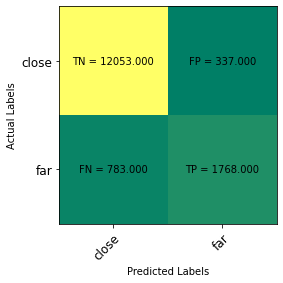

In [183]:
""" TODO
DISTANCE
Compute the confusion matrix using sklearn's confusion_matrix() function and 
generate a color map using the provided confusion_mtx_colormap() for the model 
built using the distance labels.
"""
label_names = ['close', 'far']

#calling imported function, passing over specified params
dist_confusion_mtx = confusion_matrix(dist_lbls, dist_preds)

# TODO: generate the confusion matrix color map

#calling function, passing params
confusion_mtx_colormap(dist_confusion_mtx, label_names, label_names)


nneg = dist_confusion_mtx[0].sum()
npos = dist_confusion_mtx[1].sum()
npos, nneg

(1447, 13494)

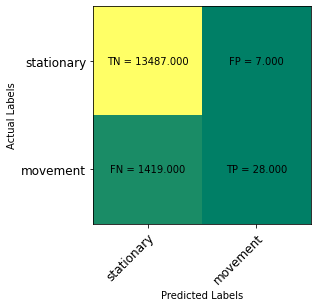

In [184]:
""" TODO
SPEED
Compute the confusion matrix using sklearn's confusion_matrix() function and 
generate a color map using the provided confusion_mtx_colormap() for the model 
built using the speed labels.
"""
label_names = ['stationary', 'movement']

#calling imported function, passing params
spd_confusion_mtx = confusion_matrix(spd_lbls, spd_preds)

# TODO: generate the confusion matrix color map

#calling function, passing params
confusion_mtx_colormap(spd_confusion_mtx, label_names,label_names)

nneg = spd_confusion_mtx[0].sum()
npos = spd_confusion_mtx[1].sum()
npos, nneg

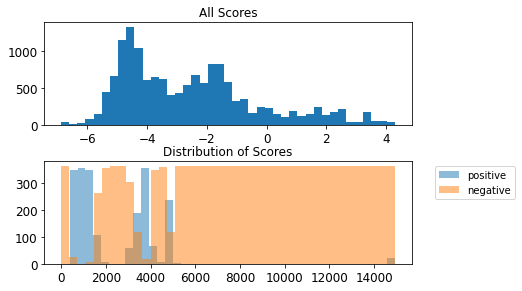

In [95]:
""" TODO
DISTANCE
Plot histograms of the scores from the model built using the distance labels.
Comparing distribution of scores for positive and negative examples.
Create one subplot of the distribution of all the scores. 
Create a second subplot overlaying the distribution of the scores of the positive
examples (i.e. positive here means examples with a label of 1) with the distribution 
of the negative examples (i.e. negative here means examples with a label of 0).
Use 41 as the number of bins.
See the lecture on classifiers for examples
"""

#creating two subplots
fig, axs = plt.subplots(2)
fig.tight_layout()

#plotting all scores
axs[0].set_title('All Scores')
axs[0].hist(dist_scores, bins=41)
#plotting with overlay labels with 1s and labels with 0s
axs[1].set_title('Distribution of Scores')
axs[1].hist(np.where(dist_preds==1), bins=41, alpha=.5, label='positive')
axs[1].hist(np.where(dist_preds==0), bins=41, alpha=.5, label='negative')
#moved legend to outsite to better show data
axs[1].legend(bbox_to_anchor=(1.05, 1))


[-3.08103785 -1.92685263 -2.40762441 ... -1.68741809 -1.508863
 -1.39688691]


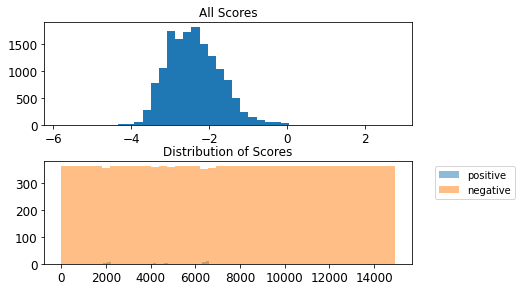

In [94]:
""" TODO
SPEED
Plot histograms of the scores from the model built using the speed labels.
Comparing distribution of scores for positive ang negative examples.
Create one subplot of the distribution of all the scores. 
Create a second subplot overlaying the distribution of the scores of the positive
examples (i.e. positive here means examples with a label of 1) with the distribution 
of the negative examples (i.e. negative here means examples with a label of 0).
Use 41 as the number of bins.
See the lecture on classifiers for examples
"""

#creating two subplots
fig, axs = plt.subplots(2)
fig.tight_layout()
#plotting all scores
axs[0].set_title('All Scores')
axs[0].hist(spd_scores, bins=41)
#plotting with overlay labels with 1s and labels with 0s
axs[1].set_title('Distribution of Scores')
axs[1].hist(np.where(spd_preds==1), bins=41, alpha=.5, label='positive')
axs[1].hist(np.where(spd_preds==0), bins=41, alpha=.5, label='negative')
axs[1].legend(bbox_to_anchor=(1.05, 1))


AUC: 0.9387806266291938


(array([0.        , 0.        , 0.        , ..., 0.67231638, 0.67231638,
        1.        ]),
 array([0.00000000e+00, 3.92003136e-04, 1.73265386e-01, ...,
        9.99607997e-01, 1.00000000e+00, 1.00000000e+00]),
 array([ 5.30879049,  4.30879049,  2.5764396 , ..., -4.38496692,
        -4.38531815, -6.8798203 ]),
 0.9387806266291938,
 <Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:xlabel='threshold', ylabel='fraction'>,
        <AxesSubplot:xlabel='FPR', ylabel='TPR'>], dtype=object))

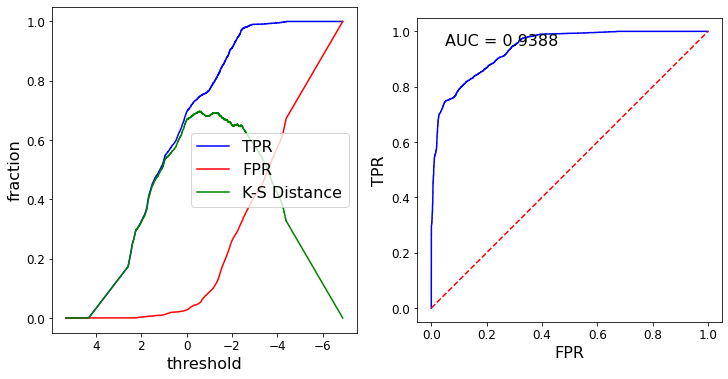

In [108]:
""" TODO
DISTANCE
Use ks_roc_plot() to plot the ROC curve and the KS plot for the model
constructed with the distance labels
"""

#calling function, passing params
ks_roc_plot(dist_lbls, dist_scores)

AUC: 0.6066875661752046


(array([0.        , 0.        , 0.        , ..., 0.99977768, 1.        ,
        1.        ]),
 array([0.00000000e+00, 6.91085003e-04, 1.38217001e-02, ...,
        9.95162405e-01, 9.95162405e-01, 1.00000000e+00]),
 array([ 3.77961032,  2.77961032,  0.27125085, ..., -4.70495674,
        -4.86784857, -5.80394828]),
 0.6066875661752046,
 <Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:xlabel='threshold', ylabel='fraction'>,
        <AxesSubplot:xlabel='FPR', ylabel='TPR'>], dtype=object))

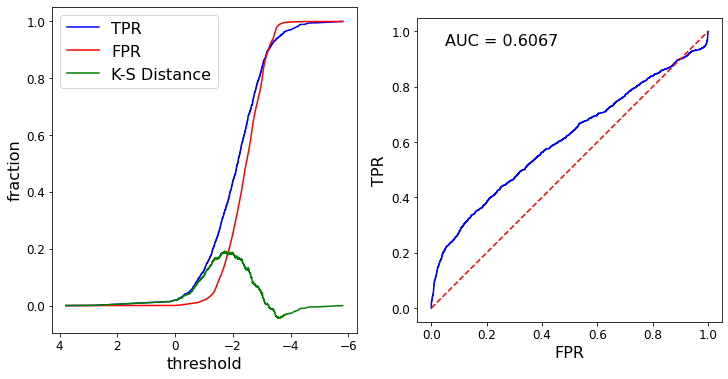

In [109]:
""" TODO
SPEED
Use ks_roc_plot() to plot the ROC curve and the KS plot for the model
constructed with the speed labels
"""

#calling function, passing params
ks_roc_plot(spd_lbls, spd_scores)